# Model Deployment using TensorFlow Serving and REST API
# Contents of Project:
- <a href='#1'>1. Save Model</a>
- <a href='#2'>2. Install TensorFlow Serving</a>
- <a href='#3'>3. Prepare Data to Send to TF Serving</a>
- <a href='#4'>4. Send & Receive JSON Data to Server via REST API</a>
- <a href='#5'>5. Evaluate</a>
- <a href='#6'>6. Bonus Image</a>

In [1]:
# Executed in Colab
!pip install -Uq grpcio==1.34.0

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import tempfile
import json
import requests

# <a id='1'>1. Save Model</a>
Currently, model is in .h5 format. To use this via TF serving, need to resave this as a SavedModel format (rather than HDF5 format).

In [2]:
model = keras.models.load_model('./hdf5/final_mobilenetv2_nn.h5')

In [3]:
MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1



INFO:tensorflow:Assets written to: /tmp/1/assets

Saved model:
total 4928
drwxr-xr-x 2 root root    4096 Jul  2 13:39 assets
-rw-r--r-- 1 root root  534250 Jul  2 13:54 keras_metadata.pb
-rw-r--r-- 1 root root 4498881 Jul  2 13:54 saved_model.pb
drwxr-xr-x 2 root root    4096 Jul  2 13:54 variables


 # <a id='2'>2. Install TensorFlow Serving</a>

In [4]:
import sys
# Sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
    SUDO_IF_NEEDED = 'sudo'
else:
    SUDO_IF_NEEDED = ''

In [5]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  84085      0 --:--:-- --:--:-- --:--:-- 84085
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 https://developer.download.nvidia.com/comp

In [6]:
!{SUDO_IF_NEEDED} apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.5.1).
0 upgraded, 0 newly installed, 0 to remove and 89 not upgraded.


In [7]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [8]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=animal10_image_classifier \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [9]:
!cat server.log

# <a id='3'>3. Prepare Data to Send to TF Serving</a>

10 instances from Animals-10 Dataset, split between the image (X) and label (y).

In [10]:
X = np.load('./inputs/production_images.npy')
y = np.load('./inputs/production_labels.npy')

In [11]:
input_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": X.tolist()
})

In [12]:
#input_data_json

# <a id='4'>4. Send & Receive JSON Data to Server via REST API</a>

In [13]:
SERVER_URL = 'http://localhost:8501/v1/models/animal10_image_classifier:predict'

In [14]:
response = requests.post(SERVER_URL, data=input_data_json)
response.raise_for_status()
response = response.json()

In [15]:
y_proba = np.array(response['predictions'])

# <a id='5'>5. Evaluate</a>

In [16]:
class_names =  {0:"Dog",
                1:"Horse",
                2:"Elephant",
                3:"Butterfly",
                4:"Chicken",
                5:"Cat",
                6:"Cow",
                7:"Sheep",
                8:"Spider",
                9:"Squirrel"
               }

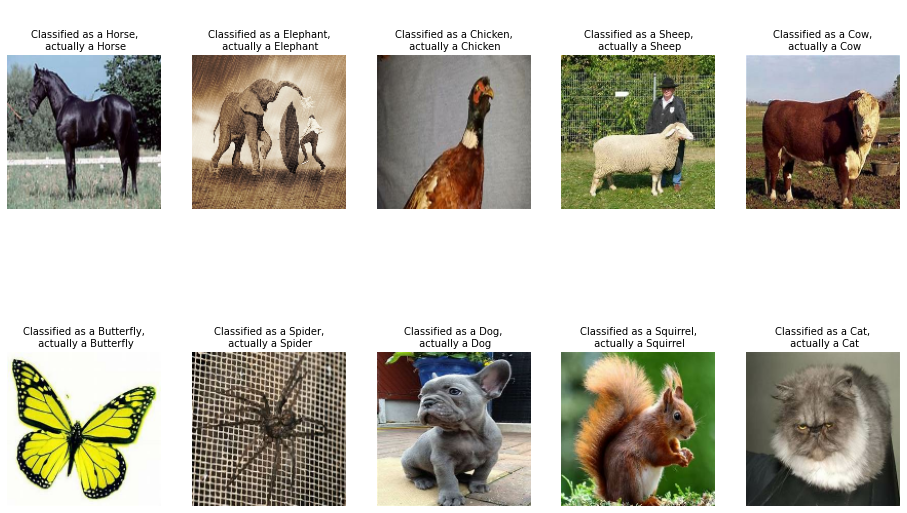

In [17]:
f, ax = plt.subplots(2,5,figsize=(16,10))
for i in range(len(y)):
    title = f'Classified as a {class_names[np.argmax(y_proba[i])]},\n actually a {class_names[y[i]]}'
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(X[i].astype(np.uint8))
    plt.axis('off')
    plt.title('\n\n{}'.format(title), fontdict={'size': 10})

In this sample of 10, the production model classified every image correctly. Image 3 (chicken) is actually an image of a pheasant, however, this was coded as a chicken in the original Animals-10 dataset and so the model has correctly classified it - the correction would be to either remove this image from the dataset, or create a new "Pheasants" category or a super category of "Birds" and have "Chickens" and "Pheasants" as sub categories.

# <a id='6'>6. Bonus Image</a>

In [18]:
bonus_img = keras.preprocessing.image.load_img('./inputs/dog.jpg')
bonus_arr = keras.preprocessing.image.img_to_array(bonus_img)
bonus_arr = np.array([bonus_arr])

In [19]:
bonus_data_json = json.dumps({
    "signature_name": "serving_default",
    "instances": bonus_arr.tolist()
})

bonus_response = requests.post(SERVER_URL, data=bonus_data_json)
bonus_response.raise_for_status()
bonus_response = bonus_response.json()

In [20]:
bonus_pred = np.argmax(np.array(bonus_response['predictions']))

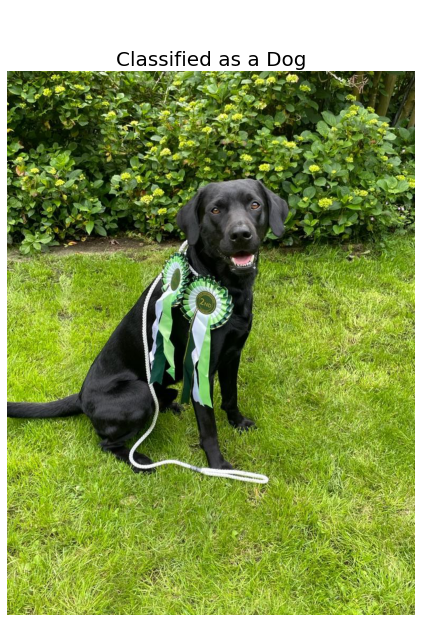

In [22]:
plt.figure(figsize=(10, 10))
title = f'Classified as a {class_names[bonus_pred]}'
plt.imshow(np.reshape(bonus_arr,(1024,768,3)).astype(np.uint8))
plt.axis('off')
plt.title('\n\n{}'.format(title), fontdict={'size': 20})
plt.show()

# References

1. The TensorFlow Authors. Train and serve a TensorFlow model with TensorFlow Serving. https://colab.research.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/serving/rest_simple.ipynb

2. Geron, A. Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow - 2nd Edition.